## Previsão de Séries Temporais com LSTM (Long Short-Term Memory)

Neste código, serão abordados os seguintes aspectos:

* Análise dos componentes da série temporal: tendência, sazonalidade e componente aleatório;
* Comparação com um método de previsão tradicional, ARIMA, utilizando métricas como RMSE, R-squared e MAE;
* Investigação da influência dos hiperparâmetros no ajuste do modelo LSTM, com o objetivo de identificar a configuração mais adequada.



O banco de dados utilizado possui duas variáveis:

* Data: Representa a data, estruturada em (Dia, Mês, Ano) e com medições mensais.

* Valor: Investimentos do Governo Federal por Função Previdência Social (R$ Milhões)

Banco de dados disponível em: https://www.tesourotransparente.gov.br/visualizacao/series-temporais-do-tesouro-nacional

In [34]:
from google.colab import files

# Use a função files.upload() para fazer o upload do arquivo do seu computador
uploaded = files.upload()


Saving Função Previdência Social - 23_7_2023 10_41.csv to Função Previdência Social - 23_7_2023 10_41 (2).csv


In [35]:
# Leitura dos dados
import pandas as pd
nome_arquivo = "Função Previdência Social - 23_7_2023 10_41.csv"

dados = pd.read_csv(nome_arquivo, sep=';',skiprows=5, encoding='utf-8')


In [36]:
# Transformando data em tempo
dados['Data'] = pd.to_datetime(dados['Data'], format='%d/%m/%Y')

# Mostrando os dados atualizados
print(dados)


          Data Valor
0   2023-05-01  1,25
1   2023-04-01   2,2
2   2023-03-01  1,32
3   2023-02-01  1,46
4   2023-01-01  1,15
..         ...   ...
180 2008-05-01  9,04
181 2008-04-01  6,55
182 2008-03-01  6,44
183 2008-02-01  4,12
184 2008-01-01  3,84

[185 rows x 2 columns]


In [37]:
# Ajuste da variável Valor

dados['Valor'] = dados['Valor'].str.replace('.', '').str.replace(',', '.')
dados['Valor'] = dados['Valor'].astype(float)

print(dados)

          Data  Valor
0   2023-05-01   1.25
1   2023-04-01   2.20
2   2023-03-01   1.32
3   2023-02-01   1.46
4   2023-01-01   1.15
..         ...    ...
180 2008-05-01   9.04
181 2008-04-01   6.55
182 2008-03-01   6.44
183 2008-02-01   4.12
184 2008-01-01   3.84

[185 rows x 2 columns]


<ipython-input-37-d8c948905be8>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dados['Valor'] = dados['Valor'].str.replace('.', '').str.replace(',', '.')


# Gráfico da série temporal

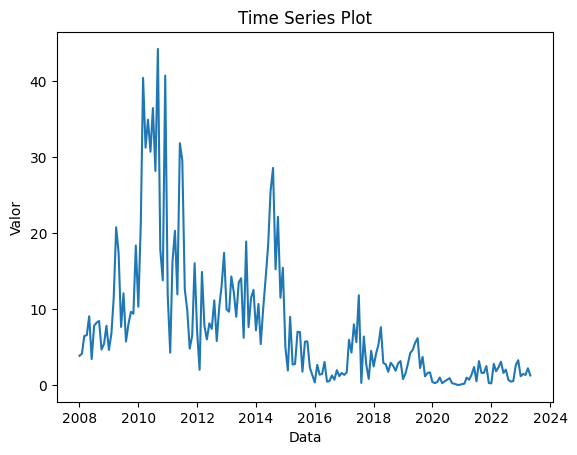

In [38]:
import matplotlib. pyplot as plt

plt.plot(dados['Data'], dados['Valor'])
plt.title('Time Series Plot')
plt.xlabel('Data')
plt.ylabel('Valor')

plt.savefig('serie.png')
plt.show()

#files.download('serie.png')

In [39]:
# Inversão do banco de dados dado que a primeira observação é a mais recente.

dados_invertidos_ts = dados.iloc[::-1]


## Componentes da série temporal: tendência, sazonalidade e componente aleatório;


In [40]:
!pip install -q scalecast

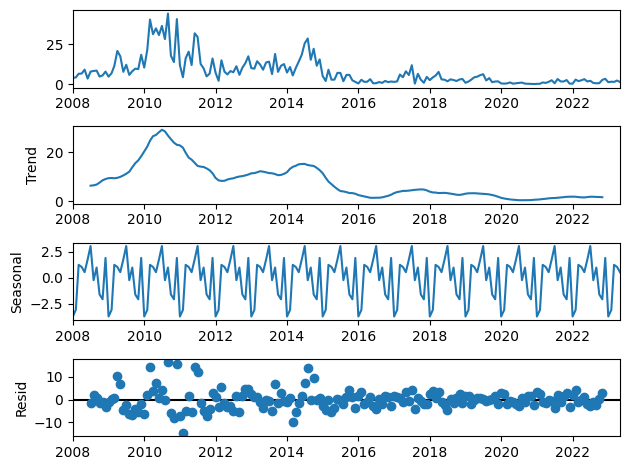

In [41]:
from scalecast.Forecaster import Forecaster

f = Forecaster(
    y=dados_invertidos_ts['Valor'],
    current_dates=dados_invertidos_ts['Data']
)

f.seasonal_decompose().plot()
plt.savefig('decompose.png')
plt.show()

#files.download('decompose.png')



## Implementação LSTM

In [42]:
from pandas import Series
import numpy as np

valores = dados_invertidos_ts['Valor']


Configurando as entradas do LSTM na seguinte estrutura:

$[\ \ x \ \ \ \ \ \ y \ \  ]$

$[x_t \ \ \ \ x_{t+1}]$

$[x_{t+1} \ x_{t+2} ]$

Nessa estrutura, temos $x$ como a entrada do modelo LSTM e $y$ como a saída (ou seja, a previsão). As linhas mostram os pares de entrada-saída, onde $x_t$ é a entrada no tempo $t$ com previsão desejada $x_{t+1}$ , $x_{t+1}$ é a entrada no tempo seguinte $t+1$ com previsão desejada  $x_{t+2}$, e assim por diante. Isso representa a configuração típica de sequências de dados para treinar um modelo LSTM, onde os dados são divididos em sequências temporais de entrada e saída. É assim que o LSTM realiza o treinamento.


In [43]:
from pandas import DataFrame
from pandas import concat
supervised_values = pd.DataFrame(valores)
columns = [supervised_values.shift(i) for i in range(1, 1+1)]
columns.append(supervised_values)
supervised_values = pd.concat(columns, axis=1)
supervised_values.fillna(0, inplace=True)

train, test = supervised_values[0:-12], supervised_values[-12:]

print(test)

    Valor  Valor
11   3.06   1.59
10   1.59   2.02
9    2.02   0.67
8    0.67   0.45
7    0.45   0.52
6    0.52   2.60
5    2.60   3.26
4    3.26   1.15
3    1.15   1.46
2    1.46   1.32
1    1.32   2.20
0    2.20   1.25


Aplicando normalização Min-Max nos dados

In [44]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

Treinamento LSTM

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
import random

X_train, y_train = train_scaled[:, 0:-1], train_scaled[:, -1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

random.seed(24392) # semente

model = Sequential()
model.add(LSTM(64, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(32, stateful=True))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.fit(X_train, y_train, epochs=20, batch_size=1, shuffle=False)

Epoch 1/20
173/173 [==============================] - 5s 3ms/step - loss: 0.1432
Epoch 2/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0909
Epoch 3/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0869
Epoch 4/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0883
Epoch 5/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0862
Epoch 6/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0807
Epoch 7/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0784
Epoch 8/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0757
Epoch 9/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0742
Epoch 10/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0722
Epoch 11/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0712
Epoch 12/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0699
Epoch 13/20
173/173 [====

Previsões do modelo LSTM:
  
As previsões podem ser feitas de duas formas:
  
Método 1 (mais usado na literatura): usar o valor verdadeiro para prever o próximo, isto é, se o interesse está em prever 12 passos a frente, temos:
  
[$x_t$] >  [$\hat{x}_{t+1}$]
  
[$x_{t+1}$] > [$\hat{x}_{t+2}$]

 Método 2: usar o valor predito para prever o próximo, isto é, se o interesse está em prever 12 passos a frente, temos:
  
[$\hat{x}_t$] >  [$\hat{x}_{t+1}$]
  
[$\hat{x}_{t+1}$] > [$\hat{x}_{t+2}$]




Método 1:

In [78]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

predictions = []
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    yhat = yhat[0, 0]

    # invertendo normalizacao
    yhat=scaler.inverse_transform([[*X[0, 0], yhat]])[0, -1]

    # previsoes
    predictions.append(yhat)


rmse = np.sqrt(mean_squared_error(valores[-12:], predictions))
r2 = r2_score(valores[-12:], predictions)
mae = mean_absolute_error(valores[-12:], predictions)

print("RMSE:", rmse)
print("R²:", r2)
print("MAE:", mae)

1/1 [==============================] - 0s 16ms/step
RMSE: 0.8769191577211237
R²: -0.1496164260519981
MAE: 0.6767455333471298


Gráfico das previsões:

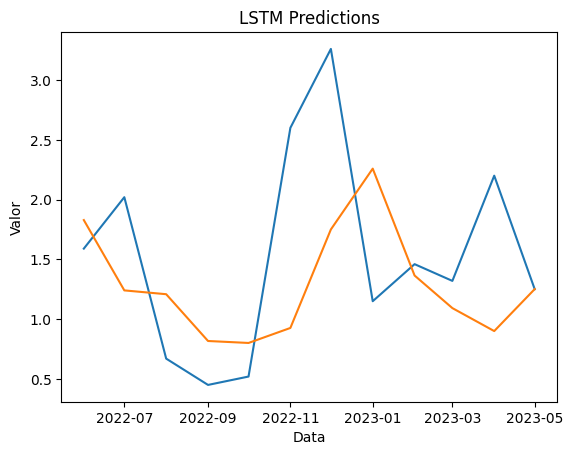

In [79]:
aba = dados_invertidos_ts[-12:]
plt.plot(aba['Data'], aba['Valor'])
plt.plot(aba['Data'], predictions)

# Set plot title and labels
plt.title('LSTM Predictions')
plt.xlabel('Data')
plt.ylabel('Valor')

# Show the plot
plt.show()

Método 2:

In [80]:
test_scaled2 = scaler.transform(test)

pred = []
for i in range(len(test_scaled)):
    X = test_scaled2[i, 0:-1]
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=1)
    yhat = yhat[0, 0]

    #test_scaled[i,1] = yhat
    if i < 11:
        test_scaled2[i+1,0] = yhat

    # invert scaling
    yhat=scaler.inverse_transform([[*X[0, 0], yhat]])[0, -1]

    # previsoes
    pred.append(yhat)


rmse = np.sqrt(mean_squared_error(valores[-12:], pred))
r2 = r2_score(valores[-12:], pred)
mae = mean_absolute_error(valores[-12:], pred)

print("RMSE:", rmse)
print("R²:", r2)
print("MAE:", mae)


1/1 [==============================] - 0s 24ms/step
RMSE: 0.8921484134115749
R²: -0.18989341020965766
MAE: 0.6431400898098947


Gráfico das previsões:

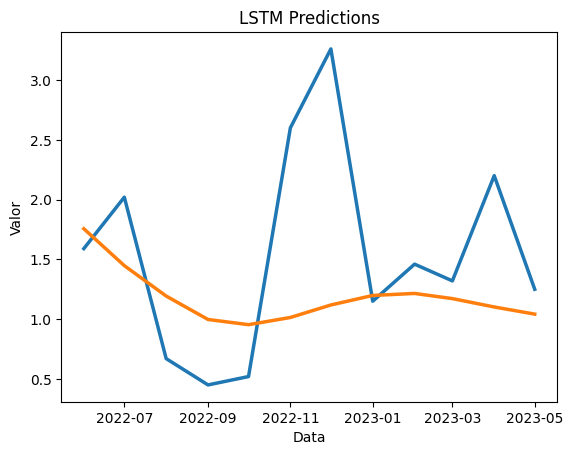

In [81]:
aba = dados_invertidos_ts[-12:]
plt.plot(aba['Data'], aba['Valor'], linewidth=2.5)
plt.plot(aba['Data'], pred, linewidth=2.5)

# Set plot title and labels
plt.title('LSTM Predictions')
plt.xlabel('Data')
plt.ylabel('Valor')

plt.savefig('lstm.png')
plt.show()

#files.download('lstm.png')

(opcional)
Esse bloco é destinado a iterar entre modelos lstm com uma semente aleatória até atingir um determinado RMSE.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
import random
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define the LSTM model
X_train, y_train = train_scaled[:, 0:-1], train_scaled[:, -1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
batch_size = 1

rmse=float('inf')
while rmse>1:

  t = random.randint(1,100000)
  print(t)
  random.seed(t)

  model = Sequential()
  model.add(LSTM(64, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True, return_sequences=True))
  model.add(LSTM(32, batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  model.fit(X_train, y_train, epochs=20, batch_size=1, shuffle=False)

  predictions = []
  for i in range(len(test_scaled)):
      X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
      X = X.reshape(1, 1, len(X))
      yhat = model.predict(X, batch_size=1)
      yhat = yhat[0, 0]

      # invertendo normalizacao
      yhat=scaler.inverse_transform([[*X[0, 0], yhat]])[0, -1]


      predictions.append(yhat)



  rmse = np.sqrt(mean_squared_error(valores[-12:], predictions))
  r2 = r2_score(valores[-12:], predictions)
  mae = mean_absolute_error(valores[-12:], predictions)

  print("RMSE:", rmse)
  print("R²:", r2)
  print("MAE:", mae)

85454
Epoch 1/20
173/173 [==============================] - 3s 2ms/step - loss: 0.1753
Epoch 2/20
173/173 [==============================] - 0s 2ms/step - loss: 0.1010
Epoch 3/20
173/173 [==============================] - 0s 2ms/step - loss: 0.1059
Epoch 4/20
173/173 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 5/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0941
Epoch 6/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0857
Epoch 7/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0795
Epoch 8/20
173/173 [==============================] - 0s 2ms/step - loss: 0.0801
Epoch 9/20
173/173 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 10/20
173/173 [==============================] - 0s 3ms/step - loss: 0.0758
Epoch 11/20
173/173 [==============================] - 1s 3ms/step - loss: 0.0710
Epoch 12/20
173/173 [==============================] - 0s 3ms/step - loss: 0.0715
Epoch 13/20
173/173

##ARIMA


In [50]:
!pip install pmdarima==2.0.3


## AUTOARIMA
Identifica o melhor ajuste para modelar a ARIMA

In [51]:
from pmdarima.arima import auto_arima

train_data = dados_invertidos_ts[:-12]

stepwise_model = auto_arima(train_data['Valor'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)


/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1089.229, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1129.261, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1102.639, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1087.229, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1127.261, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1089.228, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1085.234, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1087.233, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1087.233, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1100.640, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.849 seconds


AUTOARIMA resultou em (0,1,1), portanto, o ARIMA será ajustado com essa ordem.

In [53]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data['Valor'], order=(0,1,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Valor   No. Observations:                  173
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -540.617
Date:                Mon, 24 Jul 2023   AIC                           1085.234
Time:                        00:01:55   BIC                           1091.529
Sample:                             0   HQIC                          1087.788
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5404      0.039    -13.866      0.000      -0.617      -0.464
sigma2        31.3861      1.964     15.982      0.000      27.537      35.235
Ljung-Box (L1) (Q):                   0.00   Jarque-

## Previsões

In [54]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

arima_pred = model_fit.predict(start = len(train_data), end = len(dados_invertidos_ts)-1, typ="levels").rename("ARIMA Forecast")

rmse = np.sqrt(mean_squared_error(valores[-12:], arima_pred))
r2 = r2_score(valores[-12:], arima_pred)
mae = mean_absolute_error(valores[-12:], arima_pred)

print("RMSE:", rmse)
print("R²:", r2)
print("MAE:", mae)

RMSE: 1.2593561685523362
R²: -1.3709969315124897
MAE: 1.1014808127772886


## Gráfico das previsões

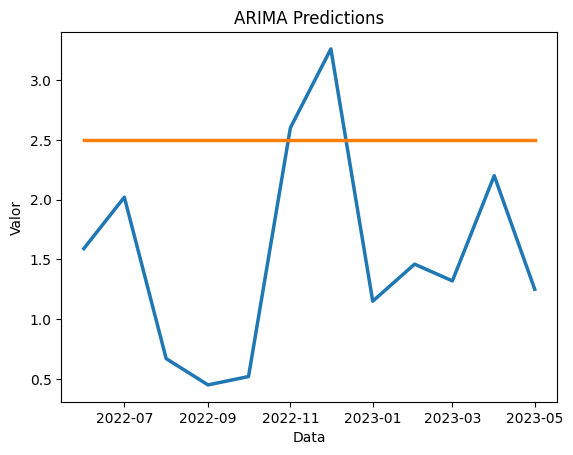

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
aba = dados_invertidos_ts[-12:]
plt.plot(aba['Data'], aba['Valor'], linewidth=2.5)
plt.plot(aba['Data'], arima_pred, linewidth=2.5)

plt.title('ARIMA Predictions')
plt.xlabel('Data')
plt.ylabel('Valor')

plt.savefig('arima.png')
plt.show()

#files.download('arima.png')

##SARIMA

In [57]:
stepwise_model = auto_arima(train_data['Valor'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1025.142, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1137.383, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1064.721, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1023.155, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1101.104, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1025.096, Time=0.67 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1025.092, Time=1.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1057.401, Time=0.16 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.31 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1057.662, Time=0.39 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1025.132, Time=0.90 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1033.745, Time=0.57 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1025.074, Time=0.63 sec

Best model:  ARIMA(0,1,1)(0,

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Especificando a ordem do modelo ARIMA
order = (0,1,1)  # Ordem do modelo ARIMA (p, d, q)
# Especificando a ordem sazonal (p, d, q) e o período sazonal (s)
seasonal_order = (0,1,1,12)  # Ordem sazonal (P, D, Q, S) e período sazonal (s)

model = SARIMAX(train_data['Valor'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

In [62]:
sarima_pred = model_fit.predict(start=len(train_data), end=len(dados_invertidos_ts) - 1, typ="levels").rename("SARIMA Forecast")

rmse = np.sqrt(mean_squared_error(valores[-12:], sarima_pred))
r2 = r2_score(valores[-12:], sarima_pred)
mae = mean_absolute_error(valores[-12:], sarima_pred)

print("RMSE:", rmse)
print("R²:", r2)
print("MAE:", mae)

RMSE: 1.5712747307661858
R²: -2.690949446541536
MAE: 1.4081437712945695


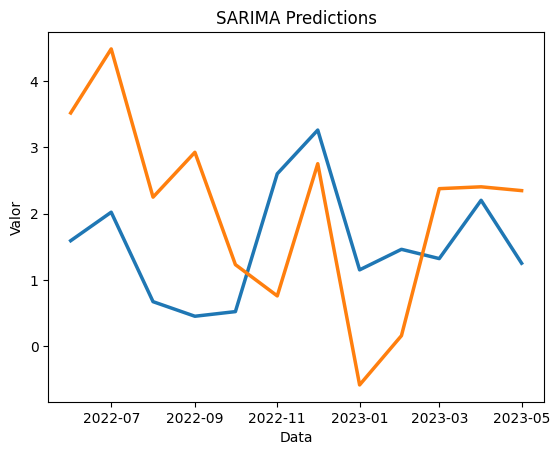

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
aba = dados_invertidos_ts[-12:]
plt.plot(aba['Data'], aba['Valor'], linewidth=2.5)
plt.plot(aba['Data'], sarima_pred, linewidth=2.5)

# Set plot title and labels
plt.title('SARIMA Predictions')
plt.xlabel('Data')
plt.ylabel('Valor')

plt.savefig('sarima.png')
plt.show()

#files.download('sarima.png')